In [187]:
import math
import numpy as np
import matplotlib.pyplot as plt
from random import Random
from time import time
from inspyred import ec, benchmarks
from collections import Counter

In [ ]:
class WorkoutRoutine(benchmarks.Benchmark):
    def __init__(self, userLevel, equipment, requestMuscles, time, userID, exercises):
        self.userLevel = userLevel.lower()
        self.time = time  # horas
        self.exercises = exercises  # diccionario {id: ejercicio}
        self.length = time * 6  # máx 6 ejercicios por hora
        self.equipment = equipment
        self.requestMuscles = requestMuscles
        self.userID = userID
        self.maximize = True
        self.bounder = ec.DiscreteBounder([1, 3005])

        self.difficulty_map = {
            "beginner": 0,
            "novice": 1,
            "intermediate": 2,
            "advanced": 3,
            "expert": 4,
            "master": 5
        }

    def generator(self, random, args):
        candidate = [random.choice(range(3005)) for _ in range(self.length)]
        return candidate
    
    def evaluator(self, candidates, args):
        fitness = []
        
        if 'metadata' not in args:
            args['metadata'] = {}

        for candidate in candidates:
            routine = self.get_exercises(candidate)
            n = len(routine)

            y_penalties = self.repetition_penalties(candidate)
            
            y_factor = sum(y_penalties) / n
            
            muscles_factor = self.trained_muscles(routine) # porcentaje de músculos entrenados
            
            difficulty_factor = self.difficulty_score(routine)
            
            if not self.equipment == "Gym":
                equipment_factor = self.used_equipment(routine)
            else:
                equipment_factor = 1  # si es gym, no penaliza por equipo

            
            value = 100 * y_factor * muscles_factor * difficulty_factor * equipment_factor
            
            # Bonus
            if value < 100:
                bonus = self.calculate_bonus(routine)
                value = min(value + bonus, 100)
                
            """ print(f"y_penalties: {y_penalties}")
            print(f"y_factor: {y_factor}")
            print(f"min_factor: {min_factor}")
            print(f"muscles_factor: {muscles_factor}")
            print(f"difficulty_factor: {difficulty_factor}")
            print(f"equipment_factor: {equipment_factor}")
            print(f"value: {value}")
            print(f"bonus: {bonus}") """
            
             # Asociar la metadata al individuo usando una tupla como clave (para que sea hashable)
            args['metadata'][tuple(candidate)] = {
                'muscles_factor': muscles_factor,
                'difficulty_factor': difficulty_factor,
                'equipment_factor': equipment_factor,
                'value': value,
                'bonus': bonus
            }

            fitness.append(value)
        return fitness

    def get_exercises(self, candidate):
        return [self.exercises[i] for i in candidate]

    def repetition_penalties(self, candidate):
        penalties = [1] * len(candidate)
        for i, eid in enumerate(candidate):
            for j in range(i):
                if candidate[j] == eid:
                    dist = i - j
                    if dist <= 2:
                        penalties[i] = 0.95
                    elif dist <= 8:
                        penalties[i] = 0.99
                    else:
                        penalties[i] = 1
                    break
        return penalties

    def difficulty_score(self, routine):
        user_level = self.difficulty_map.get(self.userLevel, 0)
        scores = []
        for ex in routine:
            ex_level = self.difficulty_map.get(ex['DifficultyLevel'].strip().lower(), 0)
            diff = ex_level - user_level
            if diff > 0:
                score = max(0, 1 - 0.2 * diff)
            else:
                score = max(0, 1 - 0.05 * abs(diff))
            scores.append(score)
        return sum(scores) / len(scores)

    def used_equipment(self, routine):
        used = set()
        for ex in routine:
            if ex['PrimaryEquipment']:
                used.add(ex['PrimaryEquipment'])
            if ex['SecondaryEquipment']:
                used.add(ex['SecondaryEquipment'])
        if not self.equipment:
            return 1
        return min(0.1 * (len(used) / len(self.equipment)) + 0.9, 1)
    
    # TODO: check the muscle factor calculation
    def trained_muscles(self, routine):
        target_muscles = [ex['TargetMuscleGroup'].strip().lower()
                        for ex in routine if ex and ex.get('TargetMuscleGroup')]
        muscle_counts = Counter(target_muscles)
        requested = [m.strip().lower() for m in self.requestMuscles]

        if not requested:
            return 1

        # 0. Nueva restricción: al menos 75% de ejercicios deben ser de músculos solicitados
        total_ex = len(routine)
        valid_ex = sum(1 for m in target_muscles if m in requested)
        required_ratio = 0.85
        if total_ex == 0 or valid_ex / total_ex < required_ratio:
            return 0  # no cumple la condición mínima

        # 1. Cobertura: cuántos músculos solicitados fueron entrenados
        covered = sum(1 for m in requested if muscle_counts[m] > 0)
        coverage = covered / len(requested)

        # 2. Equilibrio de distribución
        total_requested_ej = sum(muscle_counts[m] for m in requested)
        if total_requested_ej == 0:
            return 0
        ideal = total_requested_ej / len(requested)
        balance = 1 - (sum(abs(muscle_counts[m] - ideal) for m in requested) / total_requested_ej)

        # 3. Penalización por músculos no solicitados
        extra = [m for m in muscle_counts if m not in requested]
        penalty = len(extra) / len(muscle_counts) if muscle_counts else 1

        factor = coverage * balance 

        return max(min(factor, 1), 0)



    def calculate_bonus(self, routine):
        extra_bonus = 0
        seen_regions = set()
        for ex in routine:
            muscle = ex['TargetMuscleGroup']
            region = ex['BodyRegion']
            if muscle not in self.requestMuscles:
                if region in seen_regions:
                    extra_bonus += 0.1
                else:
                    extra_bonus += 0.05
                seen_regions.add(region)
        return extra_bonus

In [189]:
# getting the exercises form the CSV file
import pandas as pd

df = pd.read_csv('../assets/exercises.csv')

In [190]:
test = [756,983,367,1255,1234]

# Define the problem

In [191]:
# Read user csv
users_df = pd.read_csv("../assets/random_users.csv")

In [192]:
problems = []
exercises = df.to_dict(orient='records')

# Iterate over the rows of the DataFrame and create a WorkoutRoutine instance for each user
for index, row in users_df.iterrows():
    userLevel = row['userLevel']
    equipment = row['equipment'].split(';') if isinstance(row['equipment'], str) else []
    requestMuscles = row['requestMuscles'].split(';') if isinstance(row['requestMuscles'], str) else []
    duration = int(row['duration'])
    userID = int(row['userID'])
    problem = WorkoutRoutine(userLevel, equipment, requestMuscles, duration, userID, exercises)
    problems.append(problem)

In [193]:
print("Problems created:", len(problems))

Problems created: 10


# Executing the GA

In [194]:
# Initializing the observer
def diversity(population):
    return np.array([i.candidate for i in population]).std(axis=0).mean()

def fitness_diversity_observer(population, num_generations, num_evaluations, args):
    """Observer to track best fitness and diversity."""
    best = max(population).fitness
    div = diversity(population)

    args['best_fitness_historic'].append(best)
    args['diversity_historic'].append(div)

In [195]:
# Configuración única del algoritmo genético
seed = time()  # the current timestamp
prng = Random()
prng.seed(seed)

ga = ec.GA(prng)
ga.selector = ec.selectors.fitness_proportionate_selection
ga.variator = [ec.variators.n_point_crossover, ec.variators.bit_flip_mutation]
ga.replacer = ec.replacers.generational_replacement
ga.terminator = ec.terminators.generation_termination
ga.observer = [fitness_diversity_observer, ec.observers.stats_observer]

# Listas para almacenar resultados
best_candidates = []
best_fitnesses = []
best_penalties = []


# Ejecutar el GA para cada problema
for problem in problems:
    best_fitness_historic = []
    diversity_historic = []
    
    evolve_args = {
    'best_fitness_historic': best_fitness_historic,
    'diversity_historic': diversity_historic,
    'metadata': {}  # aquí se irá guardando lo que haces dentro del evaluator
    }

    final_pop = ga.evolve(
        generator=problem.generator,
        evaluator=problem.evaluator,
        bounder=problem.bounder,
        maximize=problem.maximize,
        pop_size=10000,
        max_generations=200,
        num_elites=1,
        num_selected=100,
        crossover_rate=1,
        num_crossover_points=1,
        mutation_rate=0.15,
        **evolve_args,
    )

    best = max(ga.population)
    print('User {} - Best Solution: {}: {}'.format(problem.userID, str(best.candidate), best.fitness))
    
    best_data = evolve_args['metadata'].get(tuple(best.candidate))
    print("Detalles del mejor individuo:", best_data)
    best_penalties.append(best_data)
    best_candidates.append(best.candidate)
    best_fitnesses.append(best.fitness)

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         0      10000       0.65 66.2521825 1.45000000 2.44186583 5.58150009

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         1      10100 0.89999999 66.2521825 1.90000000 16.0274800 18.8265561

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         2      10200       0.95 72.0185515 37.5176767 36.7601047 17.8757354

Generation Evaluation      Worst       Best     Median    Average    Std Dev
---------- ---------- ---------- ---------- ---------- ---------- ----------
         3      10300 0.94999999 72.0185515 48.3901875 42.4716351 19.2135912

Generation Evaluation      Worst       Best     Median    Average    Std

In [196]:
for i, problem in enumerate(problems):
    print(f"User {problem.userID} - Best Fitness: {best_fitnesses[i]}")
    print(f"User {problem.userID} - Best Candidate: {best_candidates[i]}")
    # print user requested muscles
    print(f"User {problem.userID} - Requested Muscles: {problem.requestMuscles}")
    # print user equipment
    print(f"User {problem.userID} - Equipment: {problem.equipment}")
    # print user level
    print(f"User {problem.userID} - User Level: {problem.userLevel}")
    # print user duration
    print(f"User {problem.userID} - Duration: {problem.time} hours")
    print(f"User penalties: {best_penalties[i]}")
        
            
    # Print the routine according to the best solution, ordered by TargetMuscleGroup
    sorted_routine = sorted(best_candidates[i], key=lambda x: exercises[x]['TargetMuscleGroup'])
    for i in sorted_routine:
        print("\t" + exercises[i]['TargetMuscleGroup'] + " - " + exercises[i]['DifficultyLevel'] + " - " + exercises[i]['BodyRegion'])

User 70473 - Best Fitness: 94.72857142857141
User 70473 - Best Candidate: [771, 742, 647, 1693, 1443, 262, 834, 427, 1653, 800, 592, 2069, 626, 384, 2991, 1921, 677, 2643, 2526, 1641, 865, 1364, 1603, 867, 948, 1624, 1511, 2641, 2438, 827, 2188, 1838, 2628, 85, 1626, 730, 2452, 2275, 405, 1427, 2202, 1618]
User 70473 - Requested Muscles: ['Quadriceps', 'Abdominals', 'Glutes']
User 70473 - Equipment: ['Gym']
User 70473 - User Level: advanced
User 70473 - Duration: 7 hours
User penalties: {'muscles_factor': 1.0, 'difficulty_factor': 0.9392857142857142, 'equipment_factor': 1, 'value': 94.72857142857141, 'bonus': 0.7999999999999999}
	Abdominals - Intermediate - Midsection
	Abdominals - Intermediate - Full Body
	Abdominals - Intermediate - Full Body
	Abdominals - Intermediate - Midsection
	Abdominals - Advanced - Midsection
	Abdominals - Intermediate - Midsection
	Abdominals - Advanced - Midsection
	Abdominals - Advanced - Unsorted*
	Abdominals - Intermediate - Midsection
	Abdominals - Novi

In [197]:
# Mean and standard deviation of the best fitnesses
mean_fitness = np.mean(best_fitnesses)
std_fitness = np.std(best_fitnesses)
print(f"Mean fitness: {mean_fitness}")
print(f"Standard deviation of fitness: {std_fitness}")


Mean fitness: 79.71263169642857
Standard deviation of fitness: 17.94567004406721


C:\Users\pablo\AppData\Local\Temp\ipykernel_16824\1678658813.py:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0, 0.5, 'Diversity')

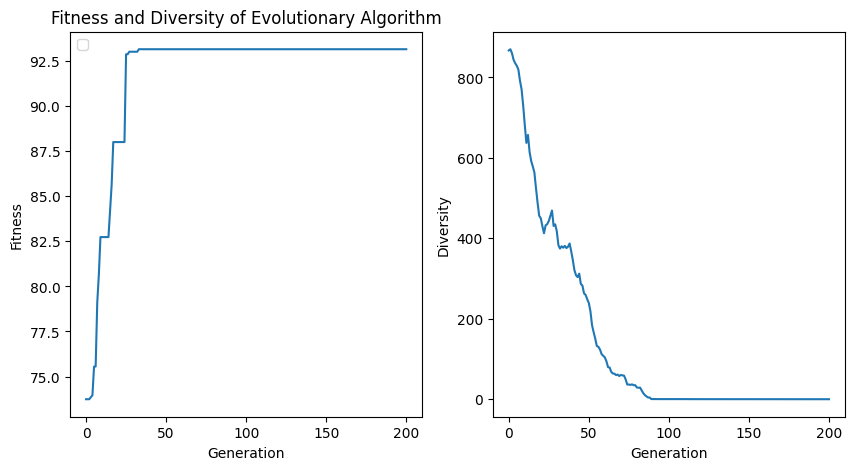

In [198]:
# plot the fitness and diversity in two separate subplots
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(best_fitness_historic)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Fitness and Diversity of Evolutionary Algorithm')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(diversity_historic)
plt.xlabel('Generation')
plt.ylabel('Diversity')